#### Objective:
This script uses **Singular Value Decomposition (SVD)** to build a recommendation system. It decomposes the user-item matrix into latent factors, reconstructs it, and predicts missing ratings to generate recommendations.

#### Data:
- `movies.csv` contains metadata (`movieId`, `title`, `genres`)
- `ratings.csv` includes user ratings (`userId`, `movieId`, `rating`, `timestamp`).

#### Input:
The ID of the target user (`target_user_id`).

#### Output:
A ranked list of recommended movies with predicted scores.

#### Pseudocode:
1. **Construct User-Item Matrix**:
   - Create matrix `R` where rows are users, columns are movies, and values are ratings.
   - Normalize `R` by subtracting the mean rating for each user: `R_demeaned = R - mean(R, axis=1)`.

2. **Perform SVD**:
   - Decompose `R_demeaned` as `U, Sigma, Vt = svd(R_demeaned, k)`, where:
     - `U`: User latent factors (`m x k`)
     - `Sigma`: Singular values (`k x k`)
     - `Vt`: Item latent factors (`k x n`).

3. **Reconstruct Predicted Ratings**:
   - Compute `R_predicted = U * Sigma * Vt + mean(R, axis=1)` to restore user means.

4. **Generate Recommendations**:
   - For the target user (`target_user_id`):
     - Retrieve predicted ratings: `predicted_ratings = R_predicted[target_user_id, :]`.
     - Exclude movies already rated by the user.
     - Rank remaining movies by predicted ratings.
     - Return the top `N` movies as recommendations.



Base Data Tables:
Movies Table: 9742 rows, 3 columns
Ratings Table: 100836 rows, 4 columns

Movies Table (Sample):
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Table (Sample):
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Step 1: Creating User-Item Matrix..

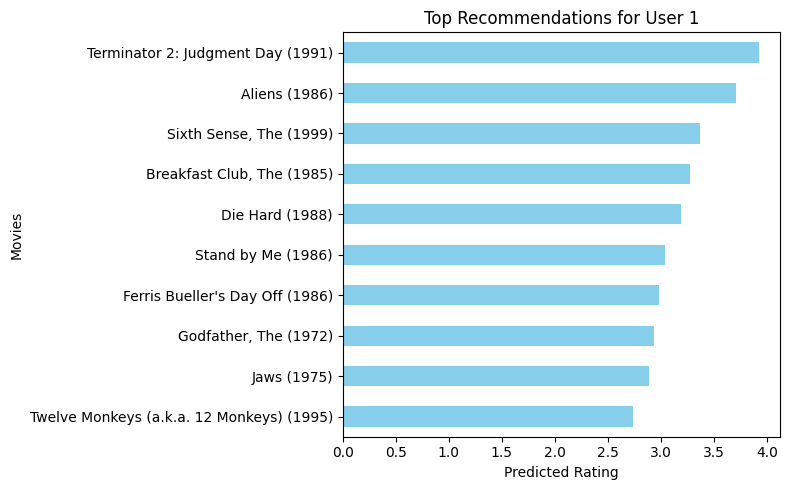

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

# Hyperparameters and Variables
path = 'data/ml-latest-small/'  # Path to dataset
movies_path = path + "movies.csv"
ratings_path = path + "ratings.csv"
latent_factors = 20  # Number of latent dimensions (k)
target_user_id = 1  # ID of the target user for recommendations
top_n_recommendations = 10  # Number of recommendations to return

# Load datasets
movies = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)

# Describe base data tables
print("\nBase Data Tables:")
print(f"Movies Table: {movies.shape[0]} rows, {movies.shape[1]} columns")
print(f"Ratings Table: {ratings.shape[0]} rows, {ratings.shape[1]} columns")

# Display sample data
print("\nMovies Table (Sample):")
print(movies.head(5))
print("\nRatings Table (Sample):")
print(ratings.head(5))

# Step 1: Create User-Item Matrix
print("\nStep 1: Creating User-Item Matrix...")
user_item_matrix = ratings.pivot(index="userId", columns="movieId", values="rating").fillna(0)
print(f"User-Item Matrix Shape: {user_item_matrix.shape}")
print("User-Item Matrix (First 5 Users, First 5 Movies):")
print(user_item_matrix.iloc[:5, :5])

# Step 2: Perform SVD
print("\nStep 2: Performing SVD...")
R = user_item_matrix.values  # Convert to NumPy array
user_ratings_mean = np.mean(R, axis=1).reshape(-1, 1)  # Compute user mean
R_demeaned = R - user_ratings_mean  # Normalize by subtracting mean

# SVD decomposition
U, sigma, Vt = svds(R_demeaned, k=latent_factors)
print(f"Shapes -> U: {U.shape}, sigma: {sigma.shape}, Vt: {Vt.shape}")

# Convert sigma into a diagonal matrix
sigma = np.diag(sigma)

# Step 3: Reconstruct User-Item Matrix
print("\nStep 3: Reconstructing User-Item Matrix...")
R_predicted = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean
print(f"Reconstructed Matrix Shape: {R_predicted.shape}")

# Step 4: Generate Recommendations
print("\nStep 4: Generating Recommendations...")
user_index = target_user_id - 1  # Adjust for zero-based indexing
predictions = R_predicted[user_index, :]  # Predicted ratings for the target user
rated_items = user_item_matrix.columns[user_item_matrix.values[user_index, :] > 0]
unrated_items = [item for item in user_item_matrix.columns if item not in rated_items]

recommendations = pd.DataFrame({
    "movieId": unrated_items,
    "predicted_rating": predictions[np.isin(user_item_matrix.columns, unrated_items)]
}).sort_values(by="predicted_rating", ascending=False).head(top_n_recommendations)

# Map Movie IDs to Titles
recommendations = recommendations.merge(movies, on="movieId")
print("\nTop 10 Recommendations:")
print(recommendations[["title", "predicted_rating"]])

# Optional: Visualization
plt.figure(figsize=(8, 5))
recommendations.set_index("title")["predicted_rating"].plot(kind="barh", color="skyblue")
plt.title(f"Top Recommendations for User {target_user_id}")
plt.xlabel("Predicted Rating")
plt.ylabel("Movies")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()